# МОДУЛЬ А

## 1.1 Загрузка данных

Первая (нулевая) строка датасета содержит техническую информацию, поэтому пропускаем её при создании датафрейма

In [581]:
# импорт необходимых модулей
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# загрузка дата-фрейма
df = pd.read_table('/content/SOP2.txt', skiprows = [0], header = None, sep = ' ').astype('int')
df.columns = ['шаг','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16']

# смотрим пустые значения и типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   шаг     1039 non-null   int64
 1   1       1039 non-null   int64
 2   2       1039 non-null   int64
 3   3       1039 non-null   int64
 4   4       1039 non-null   int64
 5   5       1039 non-null   int64
 6   6       1039 non-null   int64
 7   7       1039 non-null   int64
 8   8       1039 non-null   int64
 9   9       1039 non-null   int64
 10  10      1039 non-null   int64
 11  11      1039 non-null   int64
 12  12      1039 non-null   int64
 13  13      1039 non-null   int64
 14  14      1039 non-null   int64
 15  15      1039 non-null   int64
 16  16      1039 non-null   int64
dtypes: int64(17)
memory usage: 138.1 KB


## 1.2 Предварительное изучение

Производим анализ переменных в табличном виде (максимальное, минимальное значение, среднеквадратичное отклонение, медиана, квартили) 

In [582]:
df.describe()

,шаг,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000
mean,520.000000,0.623677,4.682387,11.102984,14.403272,68.232916,72.699711,0.738210,1.178056,41.561116,54.715111,4.525505,26.093359,61.685274,49.018287,5.670837,19.400385
std,300.077768,4.661350,17.853913,33.781258,47.885602,64.115154,68.435998,7.310799,7.571118,54.114379,70.420808,17.918007,46.546100,58.428258,68.052093,12.710252,24.494336
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,260.500000,0.000000,0.000000,0.000000,0.000000,13.000000,5.000000,0.000000,0.000000,8.000000,9.000000,0.000000,0.000000,7.000000,0.000000,0.000000,1.000000
50%,520.000000,0.000000,0.000000,0.000000,0.000000,53.000000,59.000000,0.000000,0.000000,24.000000,31.000000,0.000000,8.000000,47.000000,16.000000,0.000000,13.000000
75%,779.500000,0.000000,0.000000,1.000000,0.000000,104.500000,118.000000,0.000000,0.000000,49.000000,66.000000,0.000000,31.000000,101.000000,76.000000,4.000000,28.000000
max,1039.000000,47.000000,115.000000,255.000000,255.000000,255.000000,255.000000,152.000000,84.000000,255.000000,255.000000,147.000000,255.000000,239.000000,255.000000,93.000000,203.000000


## 1.2.1 Анализ ТЗ

Структурируем данные ТЗ для лучшего понимания задачи.

В ТЗ сказано, что из 16 представленных сигналов:
- 10 основные, из них:
    - 8 сигналов определяют продольные дефекты, из них:
        - 4 эхо сигналов, судя по схеме это:
            1. Г0 - У0 (А) - 13 строка таблицы, раздельно-совмещенная схема
            2. Г2 - У2 (Б) - 14 строка таблицы, раздельно-совмещенная схема
            3. Г5 - У5 (А) - 3 строка таблицы, хордовая схема
            4. Г6 - У6 (Б) - 4 строка таблицы, хордовая схема
        - 4 теневых сигнала, судя по схеме это:
            1. Г6 - У5 (Б - А) - 1 строка таблицы, хордовая схема
            2. Г5 - У6 (А - Б) - 2 строка таблицы, хордовая схема
            3. Г2 - У3 (Б - А) - 11 строка таблицы, раздельно-совмещенная схема
            4. Г3 - У0 (Б - А) - 12 строка таблицы, раздельно-совмещенная схема
    - 2 эхо сигнала определяют поперечные дефекты, из них:
          1. Г2 - У0 (Б - А) - 6 строка таблицы, хордовая схема
          2. Г0 - У2 (А - Б) - 5 строка таблицы, хордовая схема
- 6 повторяющиеся (эхо) с усилением +6 дБ

Графическая характеристика сигналов:
- эхо-сигнал в случае отсутствия дефекта = 0, при обнаружении дефекта на графике наблюдается всплеск.
- теневой сигнал в случае отсутствия дефекта = 255, при обнаружении дефекта на графике наблюдается провал.

Также указано, что уровень изменения сигнала зависит от высоты дефекта. В ТЗ приведен пример падения сигнала (теневой метод):
- 255 -> 245 (дельта = 10) = 2 мм высота дефекта
- 255 -> 235 (дельта = 20) = 3 мм высота дефекта 
- 255 -> 5 (дельта = 200) = 8 мм высота дефекта 

Таким образом, даны 3 точки, построим график зависимости:

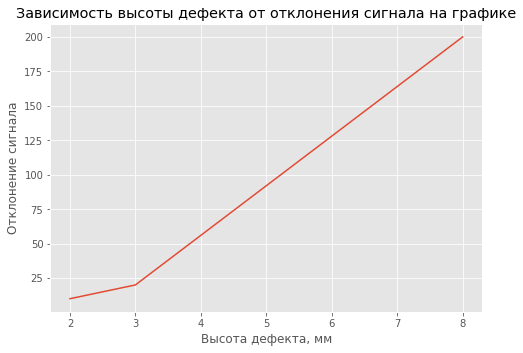

In [583]:
matplotlib.style.use('ggplot')

graph = plt.figure()
axes = graph.add_axes([0, 0, 1, 1])
axes.set_xlabel('Высота дефекта, мм')
axes.set_ylabel('Отклонение сигнала')
axes.set_title('Зависимость высоты дефекта от отклонения сигнала на графике')
axes.plot([2, 3, 8], [10, 20, 200]) 

Зависимость нелинейная. Для экономии времени проведем регрессионный анализ с использованием сервиса http://mathhelpplanet.com/static.php?p=onlayn-mnk-i-regressionniy-analiz 

Получаем квадратичную функцию:
Отклонение сигнала = 4.33 * Высота дефекта **2 - 11.66 * Высота дефекта + 16

Поскольку сигналы сильно зашумлены, для более наглядного представления попробуем восстановить идеальный эхо и теневой сигнал (без шумов) по полученной квадратичной зависимости и данных о высоте дефектов в файле target2.csv.

In [584]:
# создание датафрейма с целевой переменной
df_temp = pd.read_csv('/content/target2.csv')

# переформатируем датафрейм с целевой переменной (приведем к единой размерности с датафреймом сигналов = 1040 строк)
df2 = pd.DataFrame(columns = ['шаг', 'высота дефекта', 'тип дефекта', 'cторона', \
                   'восстановленный эхо А', 'восстановленный эхо Б', \
                   'восстановленный теневой А', 'восстановленный теневой Б']).astype('int')

for y in range(len(df)):
  exist = 0

  for x in range(len(df_temp) - 1): # удаляем последнюю строку с поперечным дефектом, без стороны
    if y >= df_temp.iloc[x, 0] - 50 and y < df_temp.iloc[x, 0] - 50 + df_temp.iloc[x, 1]: #сдвигаем на -50 от начала координат
      exist = 1
      temp_x = x
      break

  if exist > 0:  # на шаге y есть дефект
    delta_s = 4.33 * df_temp.iloc[temp_x, 2]**2 - 11.66 * df_temp.iloc[temp_x, 2] + 16 # считаем отклонения идеального сигнала
    df2.loc[y] = [y, df_temp.iloc[temp_x, 2], \
                  1 if df_temp.iloc[temp_x, 3] == 'L' else 2, \
                  1 if df_temp.iloc[temp_x, 4] == 'A' else 2, \
                  delta_s if df_temp.iloc[temp_x, 4] == 'A' else 0, \
                  delta_s if df_temp.iloc[temp_x, 4] == 'B' else 0, \
                  (255 - delta_s) if df_temp.iloc[temp_x, 4] == 'A' else 0, \
                  (255 - delta_s) if df_temp.iloc[temp_x, 4] == 'B' else 0]
  
  else:  # на шаге y нет дефекта
    df2.loc[y] = [y, 0, 0, -1, 0, 0, 255, 255]

## 1.2.2 Анализ данных в графическом виде

Построим графики зависимостей сигналов от шага движения устройства, гистограммы распределения и "ящики с усами".
Сигналы имеют диапазон от 0 до 255, поэтому для более реалистичного сопоставления сигналов зафиксируем ось y = 0...255.

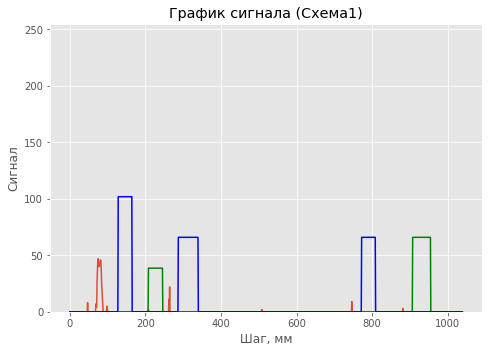

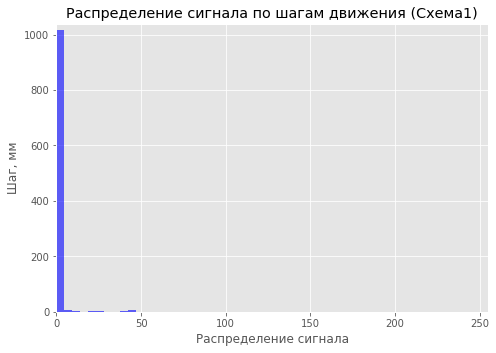

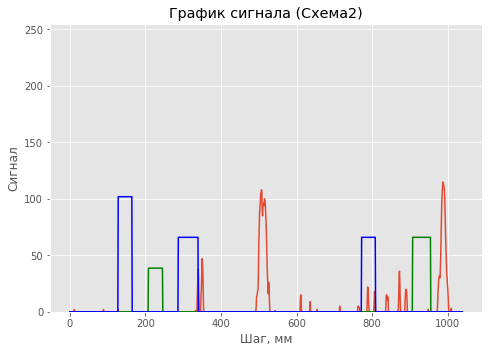

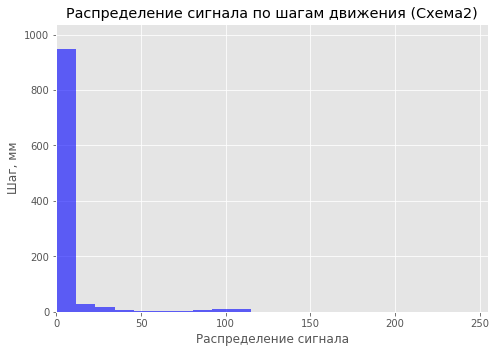

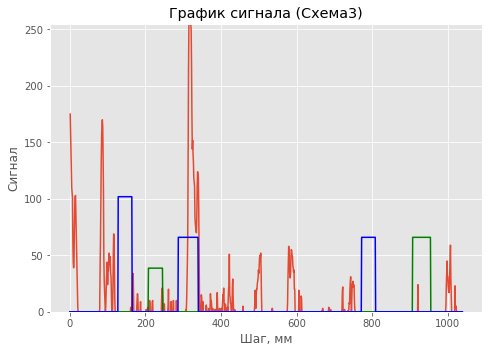

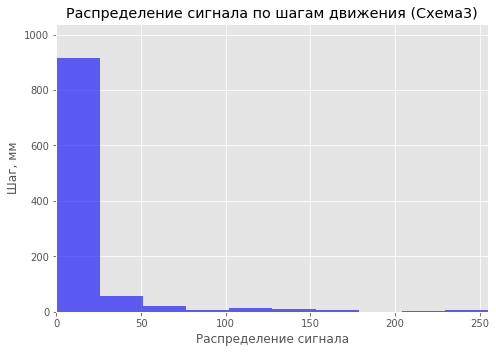

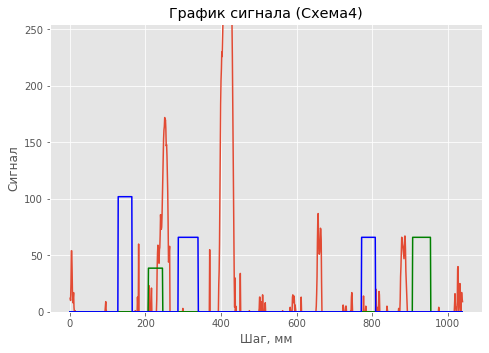

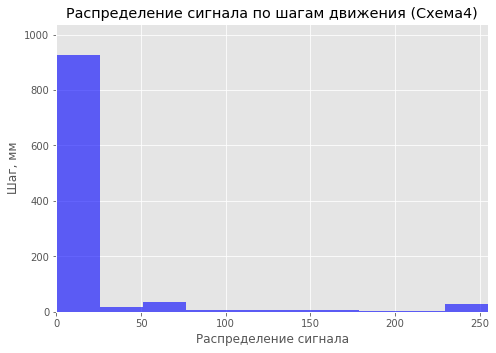

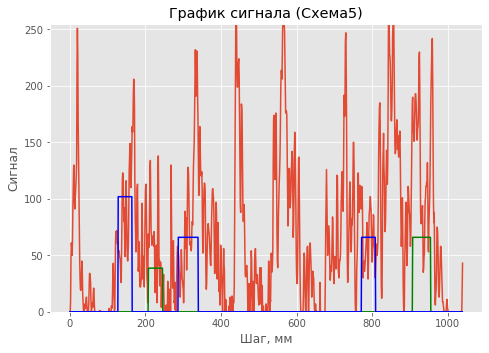

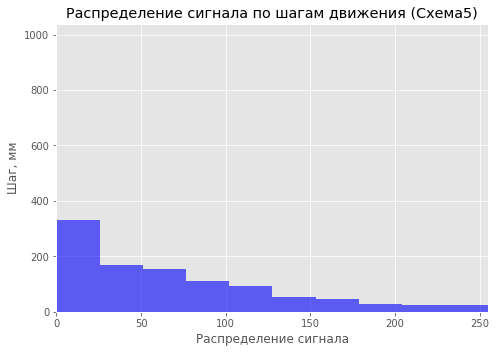

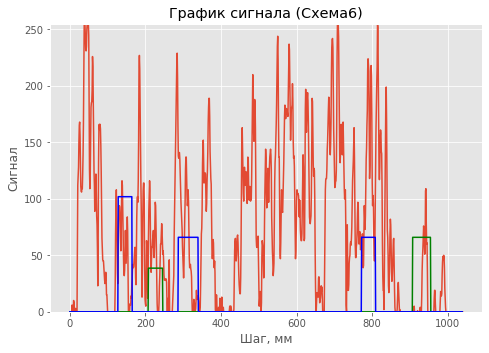

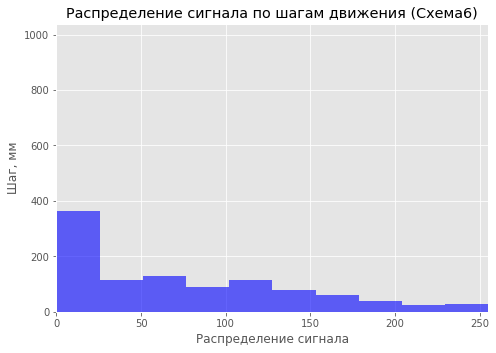

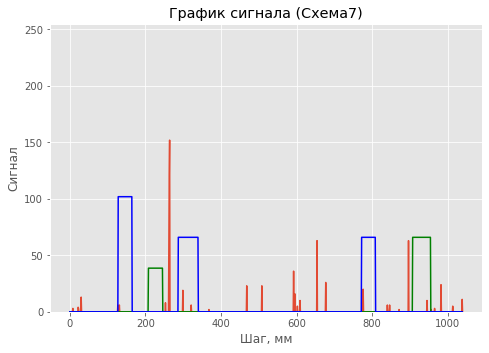

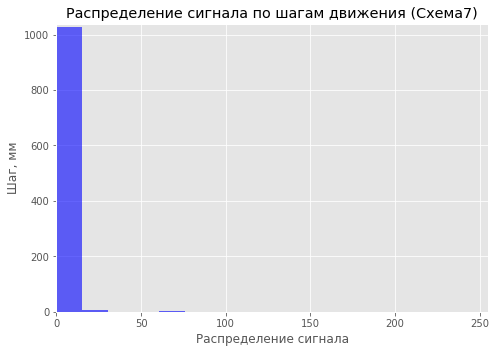

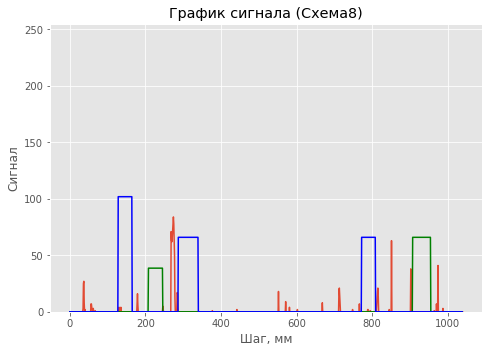

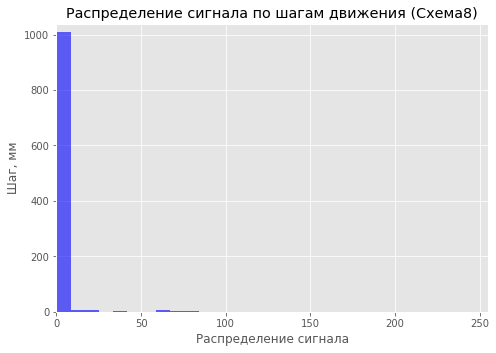

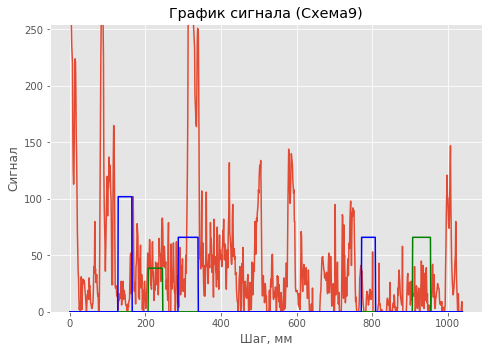

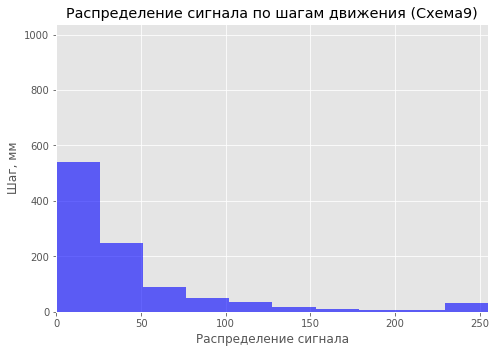

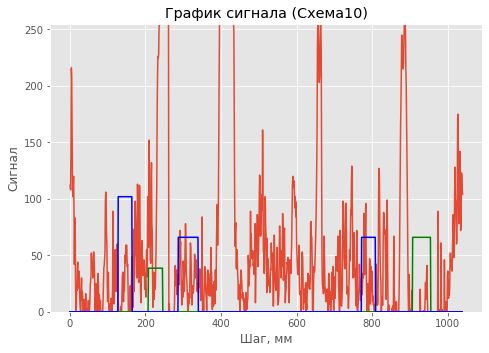

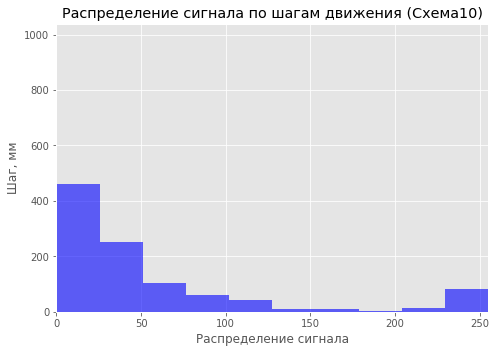

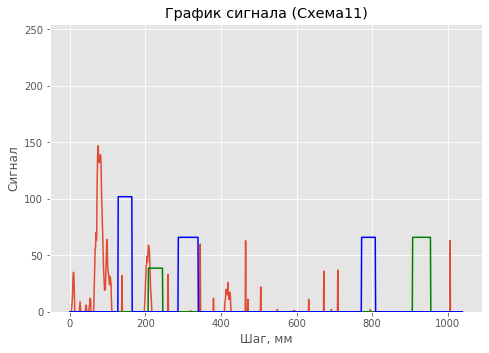

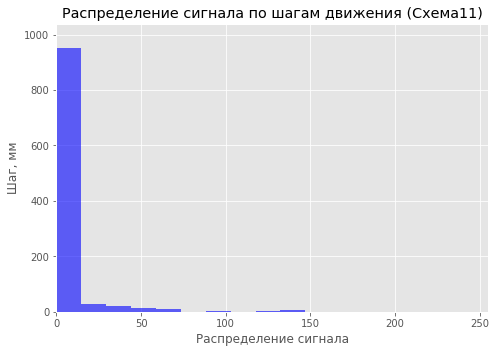

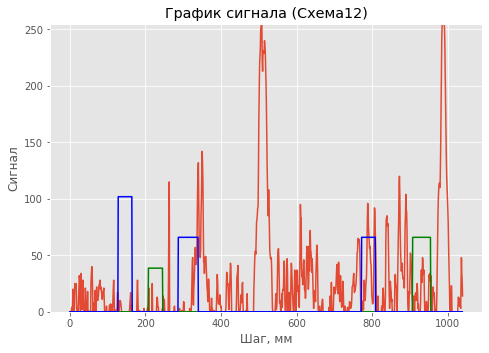

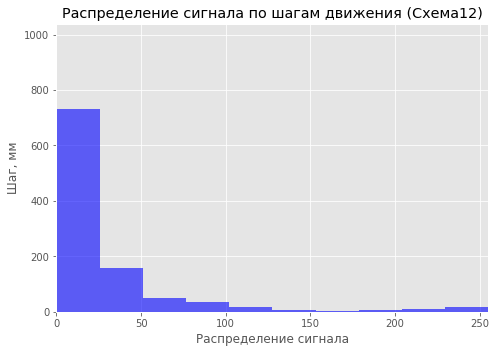

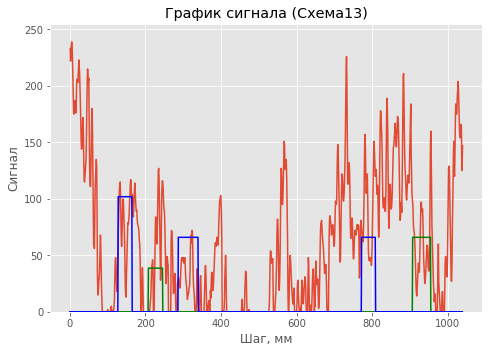

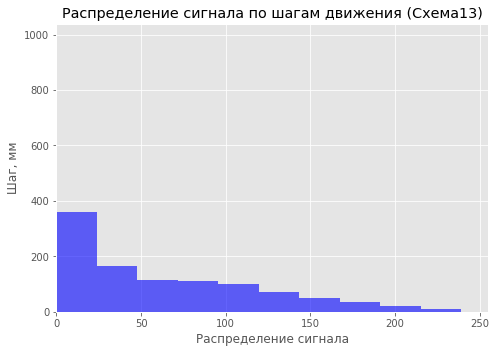

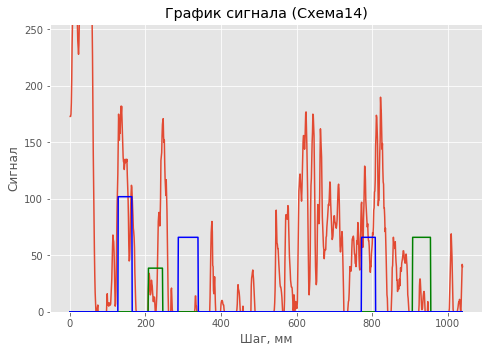

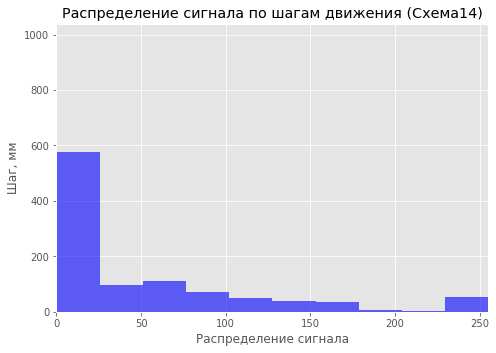

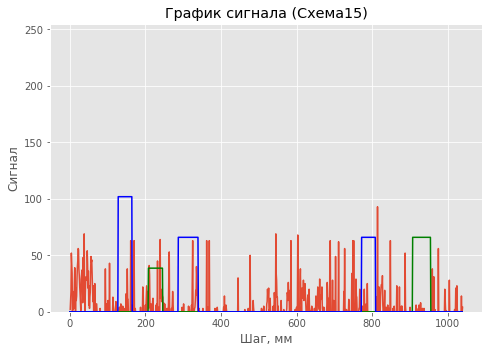

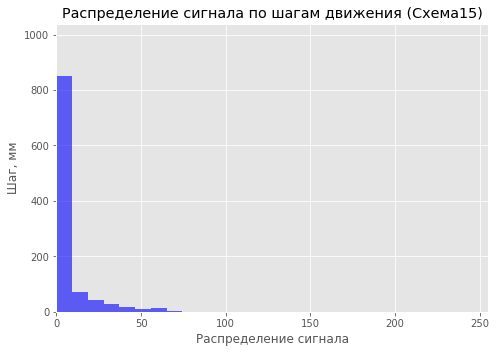

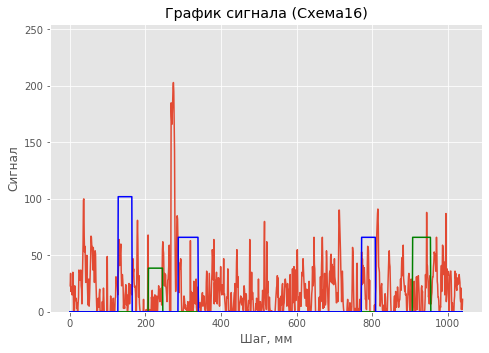

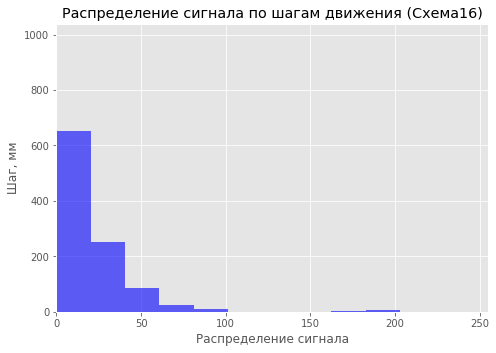

In [585]:
import warnings
warnings.filterwarnings('ignore')

for i in range(1, 17):

  # строим графики
  graph = plt.figure()
  axes = graph.add_axes([0, 0, 1, 1])
  axes.set_ylim([0, 255])
  axes.set_xlabel('Шаг, мм')
  axes.set_ylabel('Сигнал')
  axes.set_title('График сигнала (Схема' + str(i) + ')')
  axes.plot(df['шаг'], df[str(i)]) 

  # построим идеальные график эхо-сигнала для визуального сравнения и выявления эхо-графиков
  axes.plot(df2['шаг'], df2['восстановленный эхо А'], color = 'g') # дефекты на стороне А
  axes.plot(df2['шаг'], df2['восстановленный эхо Б'], color = 'b') # дефекты на стороне Б

  # строим гистограммы
  graph_hist = plt.figure()
  axes_hist = graph_hist.add_axes([0, 0, 1, 1])
  axes_hist.set_xlim([0, 255])
  axes_hist.set_ylim([0, len(df)])
  axes_hist.set_xlabel('Распределение сигнала')
  axes_hist.set_ylabel('Шаг, мм')
  axes_hist.set_title('Распределение сигнала по шагам движения (Схема' + str(i) + ')')
  axes_hist.hist(x = df[str(i)], color = 'b', alpha = 0.6)
  

Построим "ящики с усами"

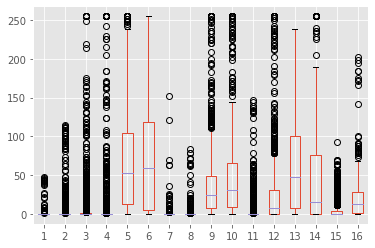

In [586]:
boxplot = df.boxplot(column = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'])

Построим матрицу корреляций, это поможет определить 6 повторяющихся сигналов с усиленной амплитудой +6 дБ. Перед построением матрицы примением сглаживание данных скользящим средним. Слишком большое окно может привести к потере данных, используем окно = 25.


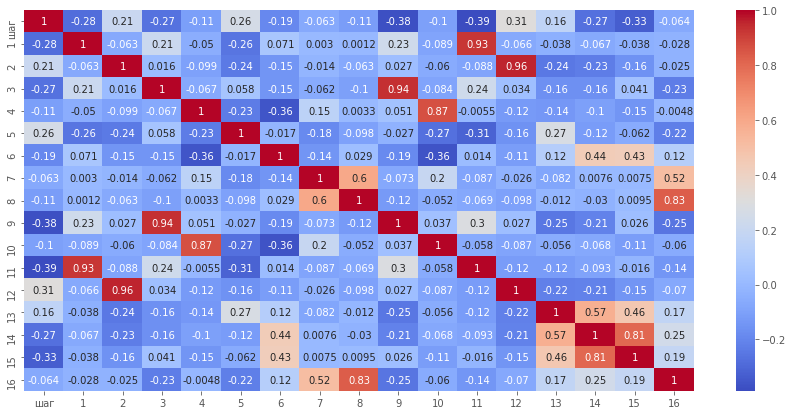

In [587]:
# сглаживание скользящим средним
rolling = df.rolling (window = 25)
rolling_mean = rolling.mean()

# корреляции
corr = rolling_mean.corr()

import seaborn as sns
fig, ax = plt.subplots(figsize = (15, 7))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', ax = ax)

Максимальные корреляции: 2 - 12, 3 - 9, 1 - 11, 4 - 10, 8 - 16, 14 - 15

## 1.3 Предварительное определение методов контроля

В ТЗ сказано, что 6 эхо-сигналов повторяются. Это одни и те же датчики, сдвига нет. Поэтому можем предположить, что наиболее коррелирующие сигналы - это те же сигналы с усилением +6 дБ. Насколько я понял, усиленные сигналы называются эхо-контактными.

Сопоставляя визуальный метод и метод с применением корреляций, определим методы УЗ контроля для каждого столбца исходных данных:

1 - эхо,
2 - эхо,
3 - эхо,
4 - эхо,
5 - теневой,
6 - теневой,
7 - теневой,
8 - эхо,
9 - эхо-контактный,
10 - эхо-контактный,
11 - эхо-контактный,
12 - эхо-контактный,
13 - теневой,
14 - эхо,
15 - эхо-контактный,
16 - эхо-контактный

# МОДУЛЬ B

## 2.1 Определение расстояния между схемами прозвучивания

В диагностическом устройстве группы датчиков расположены со смещением от начала координат. Первое смещение известно из ТЗ = 50 мм. Требуется определить второе смещение.
Самый простой и быстрый способ здесь – искать максимальную корреляцию, сдвигая часть измерений на шаг:

Напишем автоматическое определение расстояния между первым и вторым смещением датчиков.

**Внимание! После запуска этого кода желательно пойти покурить минут на 15  :)**

In [588]:
#df_temp = df.copy(deep = True)

# избавляемся от изначально коррелирующих эхо-сигналов и от теневых сигналов, оставим только однотипные сигналы (устойчивые эхо):
#del df_temp['1'] 
#del df_temp['2'] 
#del df_temp['3'] 
#del df_temp['4'] 
#del df_temp['5'] 
#del df_temp['6'] 
#del df_temp['7'] 
#del df_temp['8'] 
#del df_temp['13']
#del df_temp['14']
#del df_temp['15']
#df_temp.columns = ['шаг','1','2','3','4','5']

#max_corr = 0

#for i in range(1, 6):
  #df_temp['temp'] = df_temp[str(i)]
  #for k in range(len(df_temp)):
    #for y in range(len(df_temp)): # сдвигаем все сигналы на k += 1
      #df_temp.loc[y, 'temp'] = df_temp.loc[y - k if y >= k else len(df_temp) - k + y, str(i)]

    #corr_plus_temp = 0
    #corr_minus_temp = 0
    #for x in range(1, 6): # считаем корреляцию сдвинутого столбца с остальными столбцами
      #if x != i:
        # сглаживание скользящим средним
        #rolling = df_temp['temp'].rolling (window = 25)
        #rolling_mean = rolling.mean()
        # корреляции
        #corr = rolling_mean.corr(df_temp[str(x)])
        #if corr > 0.3:
          #corr_plus_temp += corr
        #elif corr < -0.3:
          #corr_minus_temp += corr

    #if corr_plus_temp > max_corr:
      #max_corr = corr_plus_temp
      #temp_k = k
    #elif abs(corr_minus_temp) > max_corr:
      #max_corr = abs(corr_minus_temp)
      #temp_k = k

#print('Максимальные корреляции преобладающих эхо-сигналов наблюдаются при сдвиге: ', temp_k, ' мм') # = 83 мм

**Вывод:** расстояние между схемами прозвучивания = 83 мм.

Добавим в датасет сигналы с учётом сдвига и востановленные сигналы с учетом сдвига. Возможно, это поможет сопоставить сигналы с датчиками:

In [589]:
for i in range(1, 17):
  df[str(i) + ' (-83)'] = df[str(i)]
  for y in range(len(df)):
    df.loc[y, str(i) +' (-83)'] = df.loc[y - 83 if y >= 83 else len(df) - 83 + y, str(i)]  # поворачиваем значения в столбце по кругу на -83

df['восстановленный эхо А'] = df2['восстановленный эхо А']
df['восстановленный эхо Б'] = df2['восстановленный эхо Б']
df['восстановленный теневой А'] = df2['восстановленный теневой А']
df['восстановленный теневой Б'] = df2['восстановленный теневой Б']

df['восстановленный эхо А (-83)'] = df['восстановленный эхо А']
for y in range(len(df)):
  df.loc[y, 'восстановленный эхо А (-83)'] = df.loc[y - 83 if y >= 83 else len(df) - 83 + y, 'восстановленный эхо А']

df['восстановленный эхо Б (-83)'] = df['восстановленный эхо Б']
for y in range(len(df)):
  df.loc[y, 'восстановленный эхо Б (-83)'] = df.loc[y - 83 if y >= 83 else len(df) - 83 + y, 'восстановленный эхо Б']

df['восстановленный теневой А (-83)'] = df['восстановленный теневой А']
for y in range(len(df)):
  df.loc[y, 'восстановленный теневой А (-83)'] = df.loc[y - 83 if y >= 83 else len(df) - 83 + y, 'восстановленный теневой А']

df['восстановленный теневой Б (-83)'] = df['восстановленный теневой Б']
for y in range(len(df)):
  df.loc[y, 'восстановленный теневой Б (-83)'] = df.loc[y - 83 if y >= 83 else len(df) - 83 + y, 'восстановленный теневой Б']


Построим полную матрицу корреляций всех значений с учётом сдвигов:

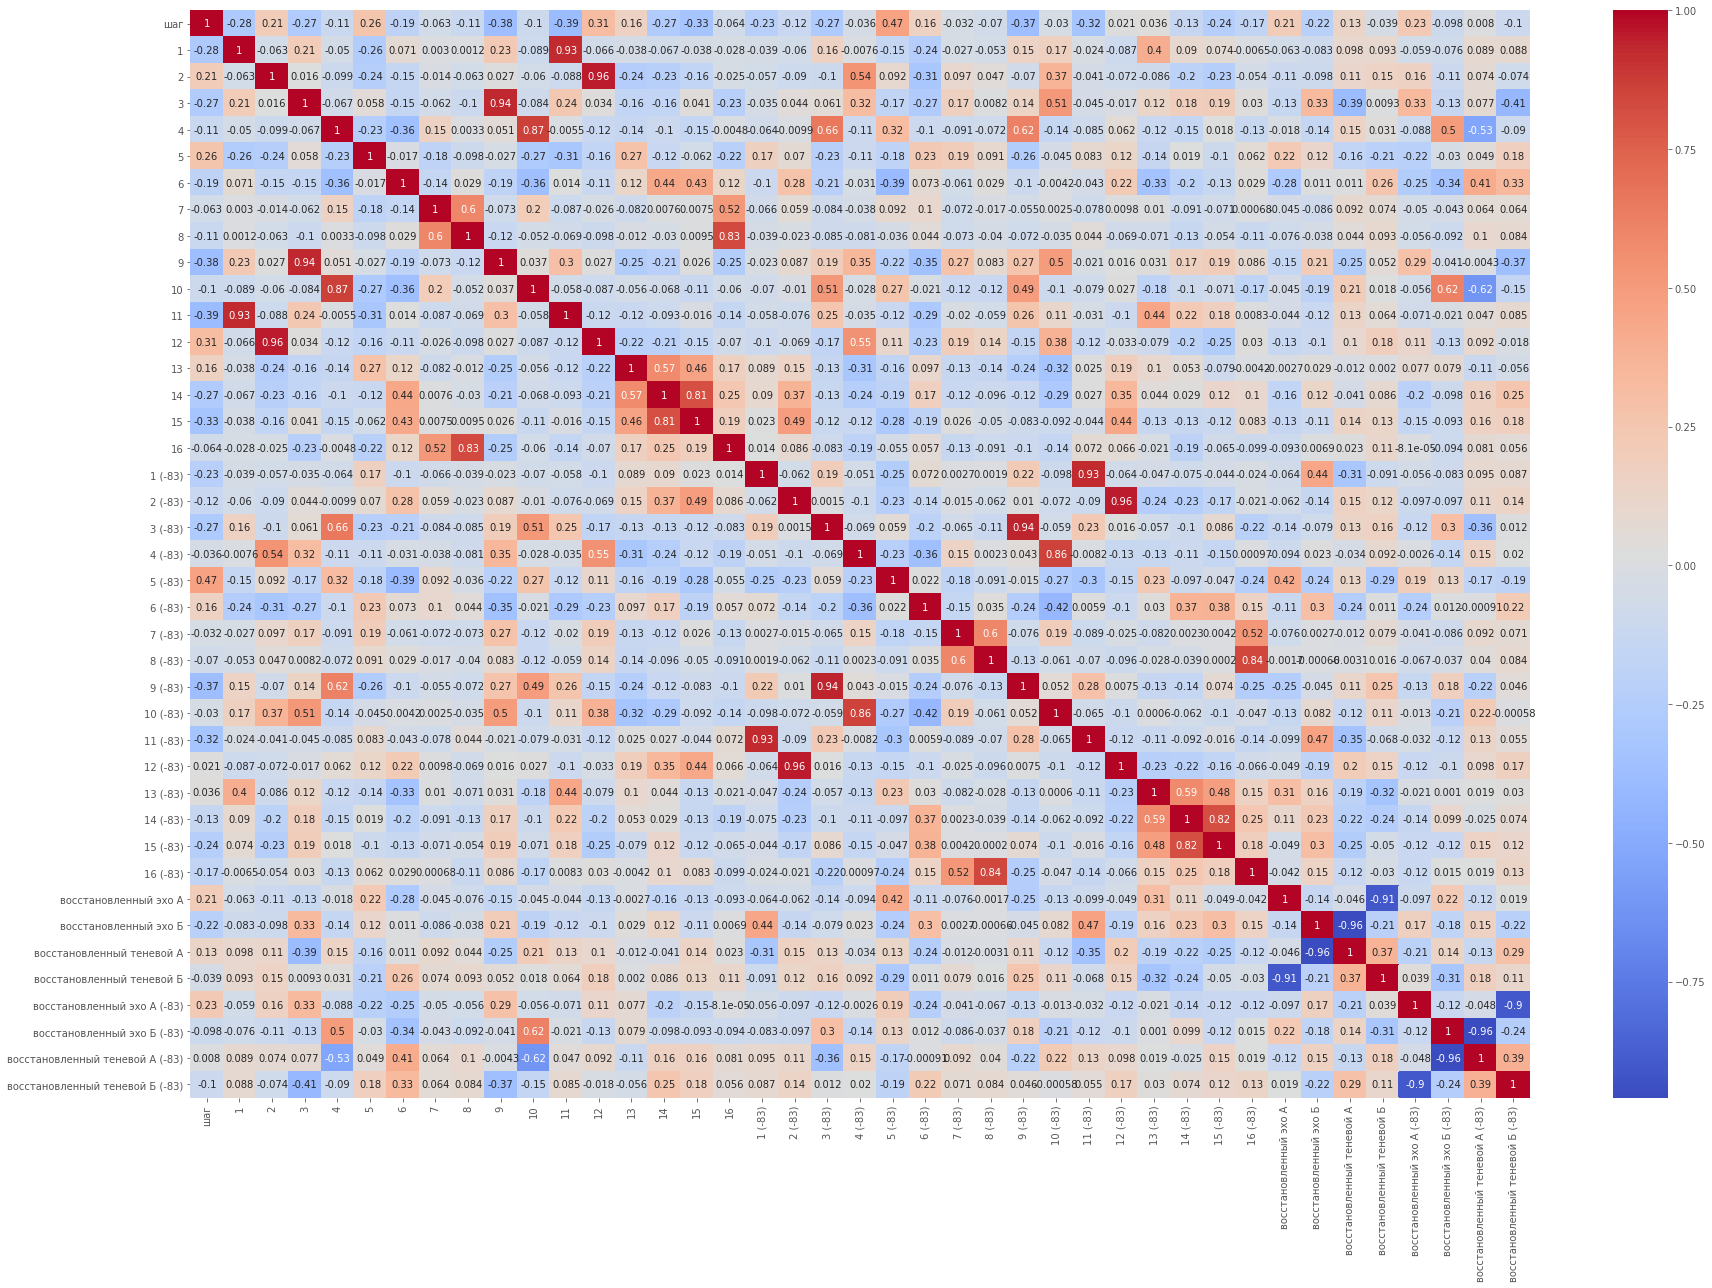

In [590]:
# сглаживание скользящим средним
rolling = df.rolling (window = 25)
rolling_mean = rolling.mean()

# корреляции
corr = rolling_mean.corr()

import seaborn as sns
fig, ax = plt.subplots(figsize = (30, 20))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', ax = ax)

**Делаем выводы:**

1. Наиболее высокий коэффициент корреляции имеют пары сигналов 2 - 12, 3 - 9, 1 - 11, 4 - 10, 8 - 16, 14 - 15. В ТЗ сказано, что 6 эхо-сигналов повторяются. Это одни и те же датчики, сдвига нет. Поэтому можем предположить, что наиболее коррелирующие сигналы - это те же сигналы с усилением +6 дБ.

2. Сигнал 3 = 9 имеет одинаковую корреляцию с восстановленным эхо сигналом на стороне А и Б = 0.33. Вероятно, датчик не находится непосредственно на стороне А или Б и определяет поперечные дефекты. 

3. Сигнал 4 = 10 имееет высокую корреляцию с восстановленным эхо на стороне Б со сдвигом - 83.

4. Сигнал 1 коррелирует с 13 со сдвигом = 0.4, вероятно между схемами 1 и 13 расстояние 83 мм

3. Сигнал 2 коррелирует с 4 (сторона А или Б, сдвиг -83) = 0.54, вероятно между схемами 2 и 4 расстояние 83 мм

6. Сигнал 7 имеет корреляцию с 8 и 16, вероятно, находятся на одной линии. Значит 5 и 6 теневые сигналы (методом исключения) - со сдвигом -83.

7. Сигнал 15 и 12 схемы находятся на расстоянии 83 мм -> 15 со сдвигом 83

8. Сигнал 8 не имеет явных корреляций по восстановленным сигналам. Значит методом исключения - без сдвига.


Распишем параметры каждого сигнала:


In [591]:
#1 = 11 - эхо (сторона А, сдвиг на -83) - вероятно это Г0-У0
#2 = 12 - эхо (сторона А, без сдвига) - вероятно это Г5-У5
#3 = 9 - эхо (сторона А, сдвиг -83) - вероятно это Г0-У2
#4 = 10 - эхо (сторона Б, сдвиг -83) - вероятно это Г2-У0
#8 = 16 - эхо (сторона Б, без сдвига) - вероятно это Г6-У6
#14 = 15 - эхо (сторона Б, сдвиг -83) - вероятно это Г2-У2

#5 - теневой (сдвиг на -83) - вероятно это Г3-У0
#6 - теневой (сдвиг на -83) - вероятно это Г2-У3
#7 - теневой (без сдвига) - вероятно это Г5-У6
#13 - теневой (без сдвига) - вероятно это Г6-У5

## 2.2 Определение схем прозвучивания

**Ранее на основе анализа ТЗ было определено:**

В ТЗ сказано, что из 16 представленных сигналов:
- 10 основные, из них:
    - 8 сигналов определяют продольные дефекты, из них:
        - 4 эхо сигналов, судя по схеме это:
            1. Г0 - У0 (А) - 13 строка таблицы, раздельно-совмещенная схема
            2. Г2 - У2 (Б) - 14 строка таблицы, раздельно-совмещенная схема
            3. Г5 - У5 (А) - 3 строка таблицы, хордовая схема
            4. Г6 - У6 (Б) - 4 строка таблицы, хордовая схема
        - 4 теневых сигнала, судя по схеме это:
            1. Г6 - У5 (Б - А) - 1 строка таблицы, хордовая схема
            2. Г5 - У6 (А - Б) - 2 строка таблицы, хордовая схема
            3. Г2 - У3 (Б - А) - 11 строка таблицы, раздельно-совмещенная схема
            4. Г3 - У0 (Б - А) - 12 строка таблицы, раздельно-совмещенная схема
    - 2 эхо сигнала определяют поперечные дефекты, из них:
          1. Г2 - У0 (Б - А) - 6 строка таблицы, хордовая схема
          2. Г0 - У2 (А - Б) - 5 строка таблицы, хордовая схема
- 6 повторяющиеся (эхо) с усилением +6 дБ

Сопоставляя данные таблицы 1 ТЗ и предположений о типах датчиков получим данные о сигналах:
1. - 13 строка таблицы, раздельно-совмещенная схема, продольные дефекты, сторона А
2. - 3 строка таблицы, хордовая схема, продольные дефекты, сторона А
3. - 5 строка таблицы, хордовая схема, поперечные дефекты, сторона А/Б
4. - 6 строка таблицы, хордовая схема, поперечные дефекты, сторона Б/А
5. - 12 строка таблицы, раздельно-совмещенная схема, продольные дефекты, сторона Б
6. - 11 строка таблицы, раздельно-совмещенная схема, продольные дефекты, сторона А
7. - 2 строка таблицы, хордовая схема, продольные и поперечные дефекты, сторона Б
8. - 4 строка таблицы, хордовая схема, продольные дефекты, сторона Б
9. - 9 строка таблицы, хордовая схема, поперечные дефекты, сторона А
10. - 10 строка таблицы, хордовая схема, поперечные дефекты, сторона Б
11. - 15 строка таблицы, раздельно-совмещенная схема, продольные дефекты, сторона А
12. - 7 строка таблицы, хордовая схема, продольные дефекты, сторона А
13. - 4 строка таблицы, хордовая схема, продольные дефекты, сторона Б
14. - 14 строка таблицы, раздельно-совмещенная схема, продольные дефекты, сторона Б
15. - 16 строка таблицы, раздельно-совмещенная схема, продольные дефекты, сторона Б
16. - 8 строка таблицы, хордовая схема, продольные дефекты, сторона Б

## 2.3 Приведение к общей координате

Дублирование и сдвиг всех столбцов уже было произведено на предыдущем этапе. Сейчас необходимо только почистить лишние данные. Некоторые столбцы оставить со сдвигом, некоторые без сдвига

In [592]:
# удалим все столбцы, ненужные более после проведения анализа:
del df['восстановленный эхо А']
del df['восстановленный эхо Б']
del df['восстановленный теневой А']
del df['восстановленный теневой Б']
del df['восстановленный эхо А (-83)']
del df['восстановленный эхо Б (-83)']
del df['восстановленный теневой А (-83)']
del df['восстановленный теневой Б (-83)']


# удалим коррелирующие столбцы (без усиления сигнала) в парах 2 - 12, 3 - 9, 1 - 11, 4 - 10, 8 - 16, 14 - 15:
del df['2']
del df['3']
del df['1']
del df['4']
del df['8']
del df['14']
del df['2 (-83)']
del df['3 (-83)']
del df['1 (-83)']
del df['4 (-83)']
del df['8 (-83)']
del df['14 (-83)']

# остаются 5 (сдвиг), 6 (сдвиг), 7, 9 (сдвиг), 10 (сдвиг), 11 (сдвиг), 12, 13, 15 (сдвиг), 16
# противоположные столбцы удаляем:

del df['5']
del df['6']
del df['7 (-83)']
del df['9']
del df['10']
del df['11']
del df['12 (-83)']
del df['13 (-83)']
del df['15']
del df['16 (-83)']

df.columns = ['шаг','1','2','3','4','5','6','7','8','9','10']

del df['шаг']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       1039 non-null   int64
 1   2       1039 non-null   int64
 2   3       1039 non-null   int64
 3   4       1039 non-null   int64
 4   5       1039 non-null   int64
 5   6       1039 non-null   int64
 6   7       1039 non-null   int64
 7   8       1039 non-null   int64
 8   9       1039 non-null   int64
 9   10      1039 non-null   int64
dtypes: int64(10)
memory usage: 81.3 KB


Приведение к общей координате осуществлено. Очистка данных завершена!

# МОДУЛЬ С

## 3.1 Разбиение данных на обучающую и тестовую выборки

Наиболее оптимальным методом разбиения является метод KFold (кросс-валидация), в результате которого получается оценка эффективности выбранной модели с наиболее равномерным использованием имеющихся данных. Но в нашем случае данных мало и они сильно зашумлены, поэтому при сокращении объема обучающей выборки модель может просто недообучиться. Поэтому применим простое разбиение на обучающую и тестовую выборку в соотношении 80/20


In [593]:
y = pd.Series(df2['cторона']) # в задании указана целевая переменная - Сторона

# сначала загружаем необходимые модули для работы
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score 
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix

# разбиение
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2)

## 3.2 Визуальное обоснование выбора переменных

Построим графики влияния переменных на целевую функцию (сторона)

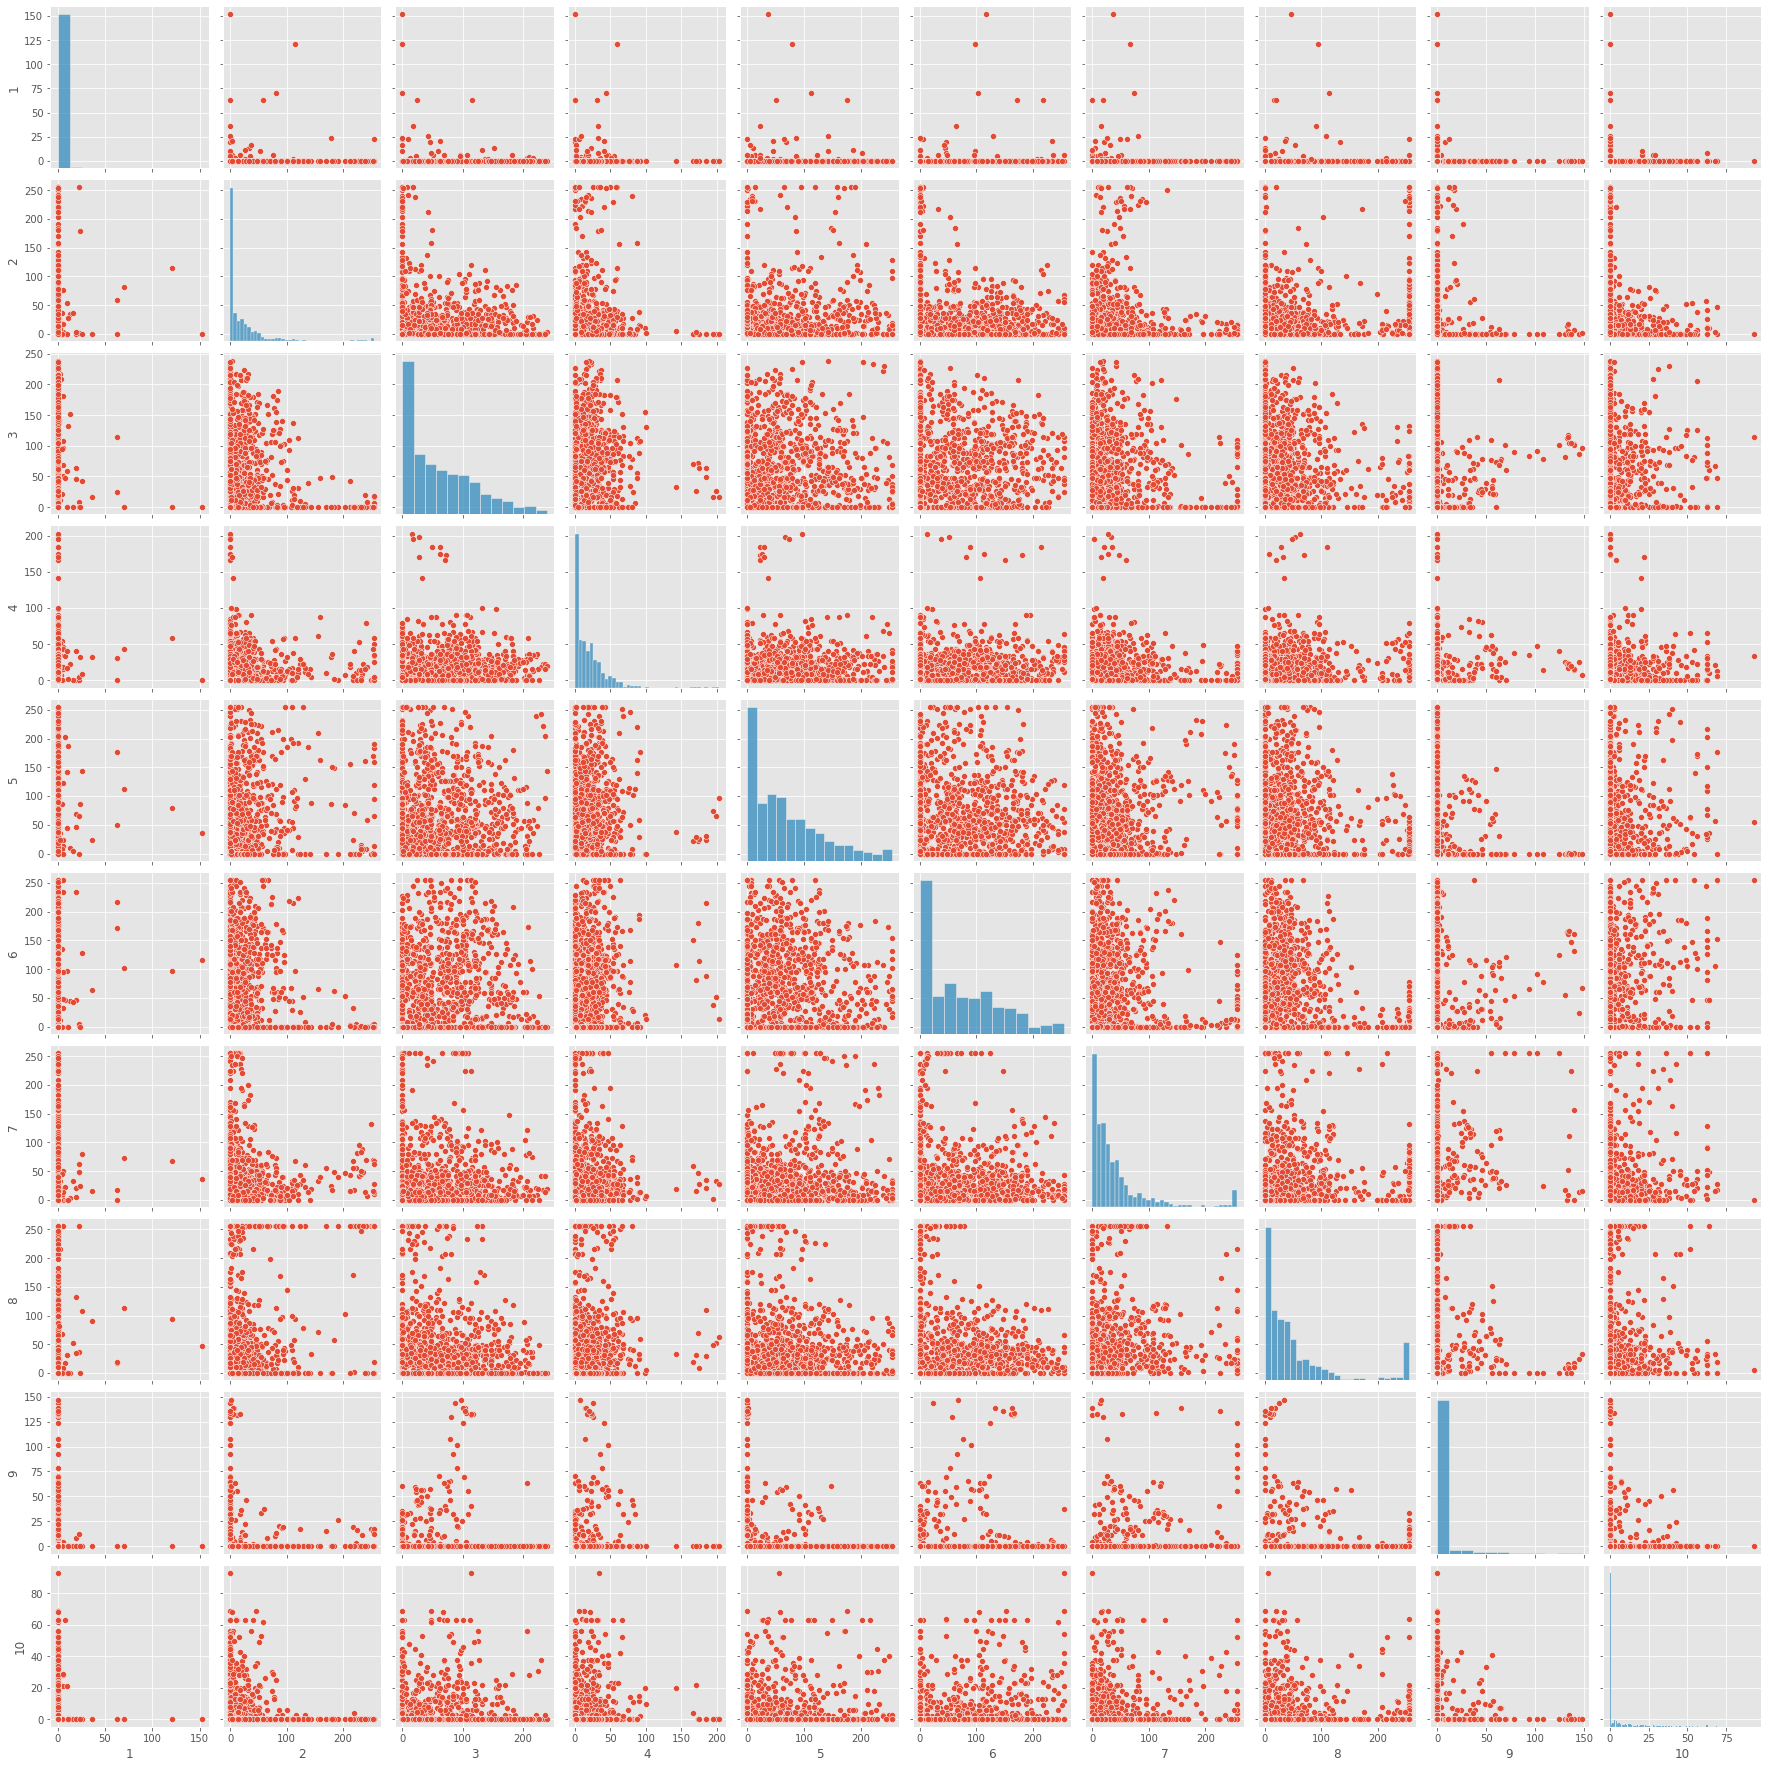

In [594]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(df)

**Вывод:** текущий сигнал 1 можно удалить ввиду неинформативности. 

In [595]:
del df['1']
df.columns = ['1','2','3','4','5','6','7','8','9']

Добавим синтетические фичи:

In [596]:
#for i in range(1, 10):
  #df[str(i) + ' (скольз.ср)'] = df[str(i)].rolling(window = 25).mean() # скользящее среднее
  #df[str(i) + ' (z-score)'] = (df[str(i)] - df[str(i)].mean())/df[str(i)].std(ddof=0) # z-score

Заново разобьём выборку:

In [597]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2)

## 3.3 Аргументированный выбор модели классификации

Для классификации рассмотрим 4 классификатора и сравним их результативность:
1. Случаный лес
2. Градиентный бустинг
3. Наивный байесовский классификатор
4. SVM-классификатор

## 3.3.1 Случайный лес


In [598]:
from sklearn.ensemble import RandomForestClassifier
predictor = RandomForestClassifier(max_depth=2, random_state=0)
classifier = predictor.fit(X_train.astype('int'), y_train.astype('int'))
y_pred = predictor.predict(X_test)

Валидация модели

In [599]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.4567307692307692

Метрики качества

In [600]:
print('accuracy: ', accuracy_score(y_pred, y_test), ', accuracy_norm: ', accuracy_score(y_pred, y_test, normalize=False), ', balanced_accuracy_score: ', balanced_accuracy_score(y_pred, y_test))
print('mean_absolute_error: ', mean_absolute_error(y_pred, y_test), ', mean_squared_error: ', mean_squared_error(y_pred, y_test))
print('cohen_kappa_score: ', cohen_kappa_score(y_pred, y_test), ', R2: ', r2_score(y_pred, y_test))

accuracy:  0.8221153846153846 , accuracy_norm:  171 , balanced_accuracy_score:  0.8221153846153846
mean_absolute_error:  0.4567307692307692 , mean_squared_error:  1.2163461538461537
cohen_kappa_score:  0.0 , R2:  0.0


Матрица ошибок

Матрица ошибок без нормализации
[[171   0   0]
 [ 16   0   0]
 [ 21   0   0]]
Нормализованная матрица ошибок
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


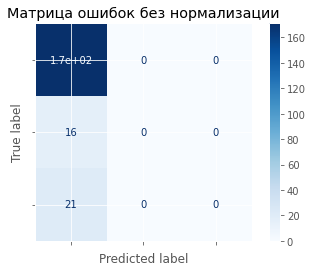

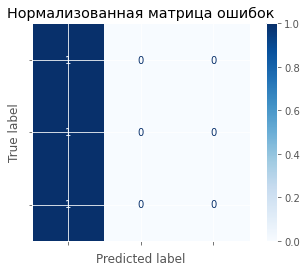

In [601]:
np.set_printoptions(precision =  2)
titles_options = [('Матрица ошибок без нормализации', None),
                 ('Нормализованная матрица ошибок', 'true')]

for title, normalize in titles_options:
  disp = plot_confusion_matrix(classifier, X_test.astype('int'), y_test.astype('int'), display_labels='', cmap=plt.cm.Blues, normalize=normalize)
  disp.ax_.set_title(title)
  print(title)
  print(disp.confusion_matrix)

plt.show()

## 3.3.2 Градиентный бустинг



In [602]:
from sklearn.ensemble import GradientBoostingClassifier
predictor = GradientBoostingClassifier(random_state=0)
classifier = predictor.fit(X_train.astype('int'), y_train.astype('int'))
y_pred = predictor.predict(X_test)

Валидация модели

In [603]:
mean_absolute_error(y_test, y_pred)

0.3173076923076923

Метрики качества

In [604]:
print('accuracy: ', accuracy_score(y_pred, y_test), ', accuracy_norm: ', accuracy_score(y_pred, y_test, normalize=False), ', balanced_accuracy_score: ', balanced_accuracy_score(y_pred, y_test))
print('mean_absolute_error: ', mean_absolute_error(y_pred, y_test), ', mean_squared_error: ', mean_squared_error(y_pred, y_test))
print('cohen_kappa_score: ', cohen_kappa_score(y_pred, y_test), ', R2: ', r2_score(y_pred, y_test))

accuracy:  0.875 , accuracy_norm:  182 , balanced_accuracy_score:  0.8659566302053349
mean_absolute_error:  0.3173076923076923 , mean_squared_error:  0.8365384615384616
cohen_kappa_score:  0.45789895749799514 , R2:  -0.7811900191938579


Матрица ошибок

Матрица ошибок без нормализации
[[169   1   1]
 [ 11   5   0]
 [ 13   0   8]]
Нормализованная матрица ошибок
[[0.99 0.01 0.01]
 [0.69 0.31 0.  ]
 [0.62 0.   0.38]]


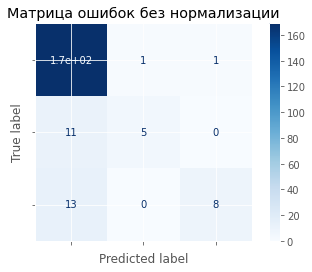

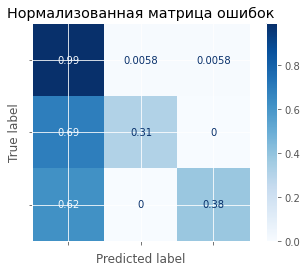

In [605]:
np.set_printoptions(precision =  2)
titles_options = [('Матрица ошибок без нормализации', None),
                 ('Нормализованная матрица ошибок', 'true')]

for title, normalize in titles_options:
  disp = plot_confusion_matrix(classifier, X_test.astype('int'), y_test.astype('int'), display_labels='', cmap=plt.cm.Blues, normalize=normalize)
  disp.ax_.set_title(title)
  print(title)
  print(disp.confusion_matrix)

plt.show()

## 3.3.3 Наивный байесовский классификатор

In [606]:
from sklearn.naive_bayes import GaussianNB
predictor = GaussianNB()
classifier = predictor.fit(X_train.astype('int'), y_train.astype('int'))
y_pred = predictor.predict(X_test)

Валидация модели

In [607]:
mean_absolute_error(y_test, y_pred)

1.0961538461538463

Метрики качества

In [608]:
print('accuracy: ', accuracy_score(y_pred, y_test), ', accuracy_norm: ', accuracy_score(y_pred, y_test, normalize=False), ', balanced_accuracy_score: ', balanced_accuracy_score(y_pred, y_test))
print('mean_absolute_error: ', mean_absolute_error(y_pred, y_test), ', mean_squared_error: ', mean_squared_error(y_pred, y_test))
print('cohen_kappa_score: ', cohen_kappa_score(y_pred, y_test), ', R2: ', r2_score(y_pred, y_test))

accuracy:  0.46634615384615385 , accuracy_norm:  97 , balanced_accuracy_score:  0.4454202339716358
mean_absolute_error:  1.0961538461538463 , mean_squared_error:  2.375
cohen_kappa_score:  0.11982006023407421 , R2:  -1.0820652063787968


Матрица ошибок

Матрица ошибок без нормализации
[[79 85  7]
 [ 0 14  2]
 [ 9  8  4]]
Нормализованная матрица ошибок
[[0.46 0.5  0.04]
 [0.   0.88 0.12]
 [0.43 0.38 0.19]]


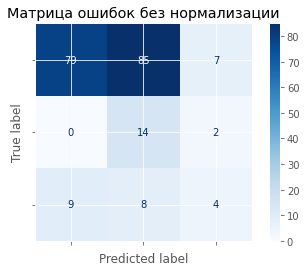

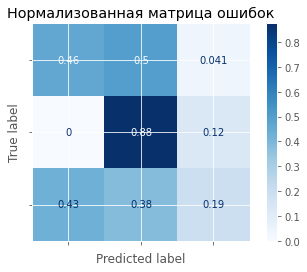

In [609]:
np.set_printoptions(precision =  2)
titles_options = [('Матрица ошибок без нормализации', None),
                 ('Нормализованная матрица ошибок', 'true')]

for title, normalize in titles_options:
  disp = plot_confusion_matrix(classifier, X_test.astype('int'), y_test.astype('int'), display_labels='', cmap=plt.cm.Blues, normalize=normalize)
  disp.ax_.set_title(title)
  print(title)
  print(disp.confusion_matrix)

plt.show()

## 3.3.4 SVM-классификатор

In [610]:
from sklearn import svm
predictor = svm.SVC(kernel='linear', C=0.01)
classifier = predictor.fit(X_train.astype('int'), y_train.astype('int'))
y_pred = predictor.predict(X_test)

Валидация модели

In [611]:
mean_absolute_error(y_test, y_pred)

0.41346153846153844

Метрики качества

In [612]:
print('accuracy: ', accuracy_score(y_pred, y_test), ', accuracy_norm: ', accuracy_score(y_pred, y_test, normalize=False), ', balanced_accuracy_score: ', balanced_accuracy_score(y_pred, y_test))
print('mean_absolute_error: ', mean_absolute_error(y_pred, y_test), ', mean_squared_error: ', mean_squared_error(y_pred, y_test))
print('cohen_kappa_score: ', cohen_kappa_score(y_pred, y_test), ', R2: ', r2_score(y_pred, y_test))

accuracy:  0.8365384615384616 , accuracy_norm:  174 , balanced_accuracy_score:  0.7802653399668324
mean_absolute_error:  0.41346153846153844 , mean_squared_error:  1.0865384615384615
cohen_kappa_score:  0.19324663472507408 , R2:  -4.431311380704795


Матрица ошибок:

Матрица ошибок без нормализации
[[169   2   0]
 [ 14   2   0]
 [ 18   0   3]]
Нормализованная матрица ошибок
[[0.99 0.01 0.  ]
 [0.88 0.12 0.  ]
 [0.86 0.   0.14]]


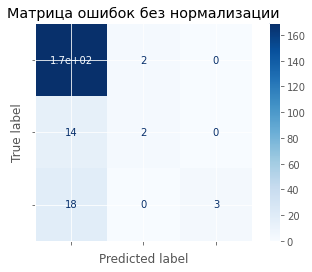

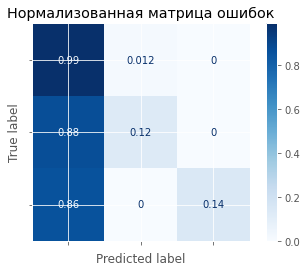

In [613]:
np.set_printoptions(precision =  2)
titles_options = [('Матрица ошибок без нормализации', None),
                 ('Нормализованная матрица ошибок', 'true')]

for title, normalize in titles_options:
  disp = plot_confusion_matrix(classifier, X_test.astype('int'), y_test.astype('int'), display_labels='', cmap=plt.cm.Blues, normalize=normalize)
  disp.ax_.set_title(title)
  print(title)
  print(disp.confusion_matrix)

plt.show()

## Вывод

Были опробованы 4 классификатора:
1. Случаный лес
2. Градиентный бустинг
3. Наивный байесовский классификатор
4. SVM-классификатор


Градиентный бустинг ожидаемо справился эффективнее остальных алгоритмов. Метрика валидации = 0.25 (чем меньше, тем лучше). Также градиентный бустинг показал самое высокое качество из представленных алгоритмов = 87%.